References:
- https://qiita.com/gensal/items/613d04b5ff50b6413aa0
- https://mbernste.github.io/posts/vae/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc

In [2]:
# Create transform to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# Download MNIST dataset
trainval_data = MNIST(root="./data", train=True, download=True, transform=transform)

# Split data to train and val
train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4)

print("train data size: ",len(train_data))
print("train iteration number: ",len(train_data)//BATCH_SIZE)
print("val data size: ",len(val_data))
print("val iteration number: ",len(val_data)//BATCH_SIZE)

train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


images_size: torch.Size([100, 1, 28, 28])
label: tensor([2, 4, 0, 5, 9, 5, 9, 5, 1, 6, 9, 1, 4, 1, 6, 2, 3, 7, 3, 4, 7, 9, 6, 2,
        5, 8, 5, 1, 9, 2, 1, 7, 9, 0, 7, 5, 2, 0, 7, 9, 6, 3, 1, 7, 9, 7, 1, 6,
        7, 7, 8, 5, 5, 3, 7, 2, 7, 3, 4, 6, 7, 7, 0, 7, 3, 6, 9, 1, 9, 3, 8, 6,
        3, 7, 2, 5, 5, 3, 4, 2, 0, 0, 8, 2, 7, 9, 2, 1, 6, 3, 2, 9, 3, 2, 1, 5,
        4, 5, 4, 6])
100


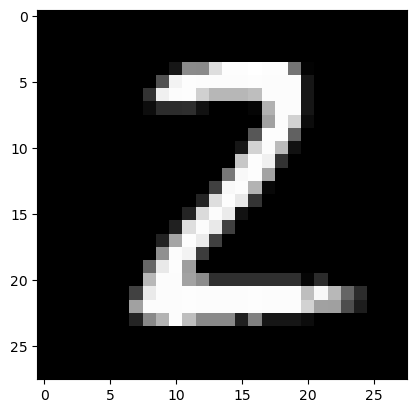

In [3]:
images, labels = next(iter(train_loader)) #Images, labels in first batch.
print("images_size:",images.size()) # [batch_size, channel, height, width]
print("label:",labels)
print(len(labels))

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

Fully connected NN-based VAE

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.lr = nn.Linear(28*28, 300)
        self.lr2 = nn.Linear(300, 100)
        self.lr_ave = nn.Linear(100, z_dim)
        self.lr_var = nn.Linear(100, z_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.lr(x))
        x = self.relu(self.lr2(x))
        ave = self.lr_ave(x)
        log_var = self.lr_var(x)

        # Reparameterization Trick
        epsilon = torch.randn_like(ave)
        z = ave + epsilon * torch.exp(log_var / 2)
        return z, ave, log_var

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.lr = nn.Linear(z_dim, 100)
        self.lr2 = nn.Linear(100, 300)
        self.lr3 = nn.Linear(300, 28*28)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.lr(x))
        x = self.relu(self.lr2(x))
        x = torch.sigmoid(self.lr3(x))
        return x

class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    
    def forward(self, x):
        z, ave, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z, ave, log_var
        

In [5]:
def loss_function(output, input, ave, log_var):
	reconstruction_loss = F.binary_cross_entropy(output, input, reduction='sum')
	kl_loss = -0.5 * torch.sum(1 + log_var - ave**2 - log_var.exp())
	loss = reconstruction_loss + kl_loss
	return loss

In [6]:
z_dim = 2
num_epochs = 20

# Check if MPS (Apple GPU support) is available and use it; otherwise, use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: mps


In [7]:
history = {"train_loss": [], "val_loss": [], "ave": [], "log_var": [], "z": [], "labels": []}

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[15], gamma=0.1)
for epoch in range(num_epochs):
    model.train()
    for batch_num, (x, labels) in enumerate(train_loader): # x.shape: [batch_size, channel, height, width]
        input = x.to(device).view(-1, 28*28).to(torch.float32) # input.shape [100, 28*28 (784)]
        output, z, ave, log_var = model(input) # z.shape: [100, 2]

        history["ave"].append(ave)
        history["log_var"].append(log_var)
        history["z"].append(z)
        history["labels"].append(labels)
        loss = loss_function(output, input, ave, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_num % 100 == 0:
            print(f'Epoch: {epoch + 1}, loss: {loss:.4f}')
        history["train_loss"].append(loss)
    
    model.eval()
    with torch.inference_mode():
        for x, labels in val_loader:
            input = x.to(device).view(-1, 28*28).to(torch.float32)
            output, z, ave, log_var = model(input)

            loss = loss_function(output, input, ave, log_var)
            history["val_loss"].append(loss)
        print(f'Epoch: {epoch + 1}, val_loss: {loss:.4f}')
    
    scheduler.step()

Epoch: 1, loss: 54415.4844
Epoch: 1, loss: 18835.6035
Epoch: 1, loss: 18000.5332
Epoch: 1, loss: 17361.9961
Epoch: 1, loss: 17010.2051
Epoch: 1, val_loss: 16856.8711
Epoch: 2, loss: 16181.3584
Epoch: 2, loss: 17427.2988
Epoch: 2, loss: 17610.7148
Epoch: 2, loss: 16480.5156
Epoch: 2, loss: 16971.8965
Epoch: 2, val_loss: 16703.6270
Epoch: 3, loss: 16242.6514
Epoch: 3, loss: 16238.4434
Epoch: 3, loss: 15698.9023
Epoch: 3, loss: 16186.3750
Epoch: 3, loss: 15609.8555
Epoch: 3, val_loss: 16472.4727
Epoch: 4, loss: 15678.0039
Epoch: 4, loss: 15771.9150
Epoch: 4, loss: 15798.1396
Epoch: 4, loss: 15454.9434
Epoch: 4, loss: 14684.0273
Epoch: 4, val_loss: 15434.3535
Epoch: 5, loss: 14957.1895
Epoch: 5, loss: 14262.3535
Epoch: 5, loss: 15516.2500
Epoch: 5, loss: 16383.3643
Epoch: 5, loss: 14363.2295
Epoch: 5, val_loss: 15500.9238
Epoch: 6, loss: 15705.8740
Epoch: 6, loss: 15673.4521
Epoch: 6, loss: 16394.6133
Epoch: 6, loss: 14521.4551
Epoch: 6, loss: 15763.0234
Epoch: 6, val_loss: 14457.7344
Epoc

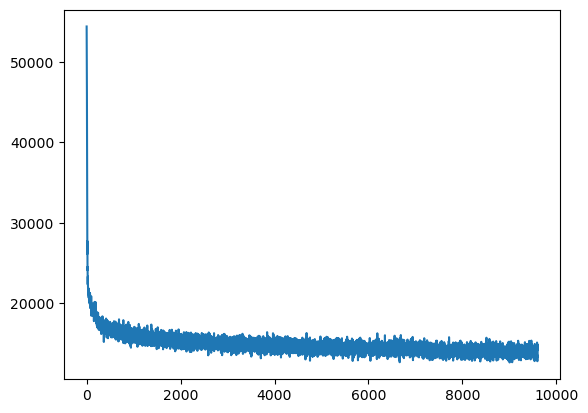

In [8]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

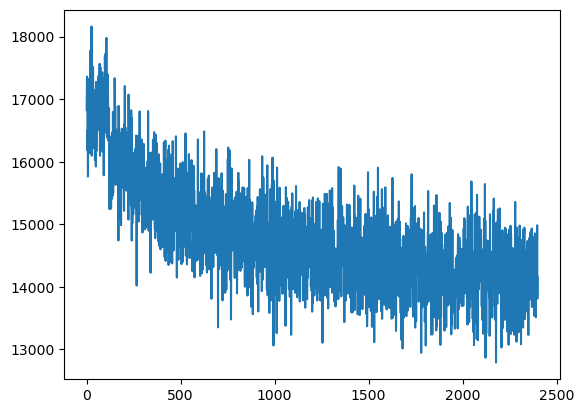

In [29]:
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)

In [35]:
ave_tensor = torch.stack(history["ave"])
log_var_tensor = torch.stack(history["log_var"])
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(f"Average: {ave_tensor.size()}") # total batch number is 480 cuz batch size is 100. 480 (total batch number) * 20 (epochs number) = 9600
print(f"Log Variance: {log_var_tensor.size()}")
print(f"z: {z_tensor.size()}")
print(f"Labels: {labels_tensor.size()}")

ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()

Average: torch.Size([9600, 100, 2])
Log Variance: torch.Size([9600, 100, 2])
z: torch.Size([9600, 100, 2])
Labels: torch.Size([9600, 100])


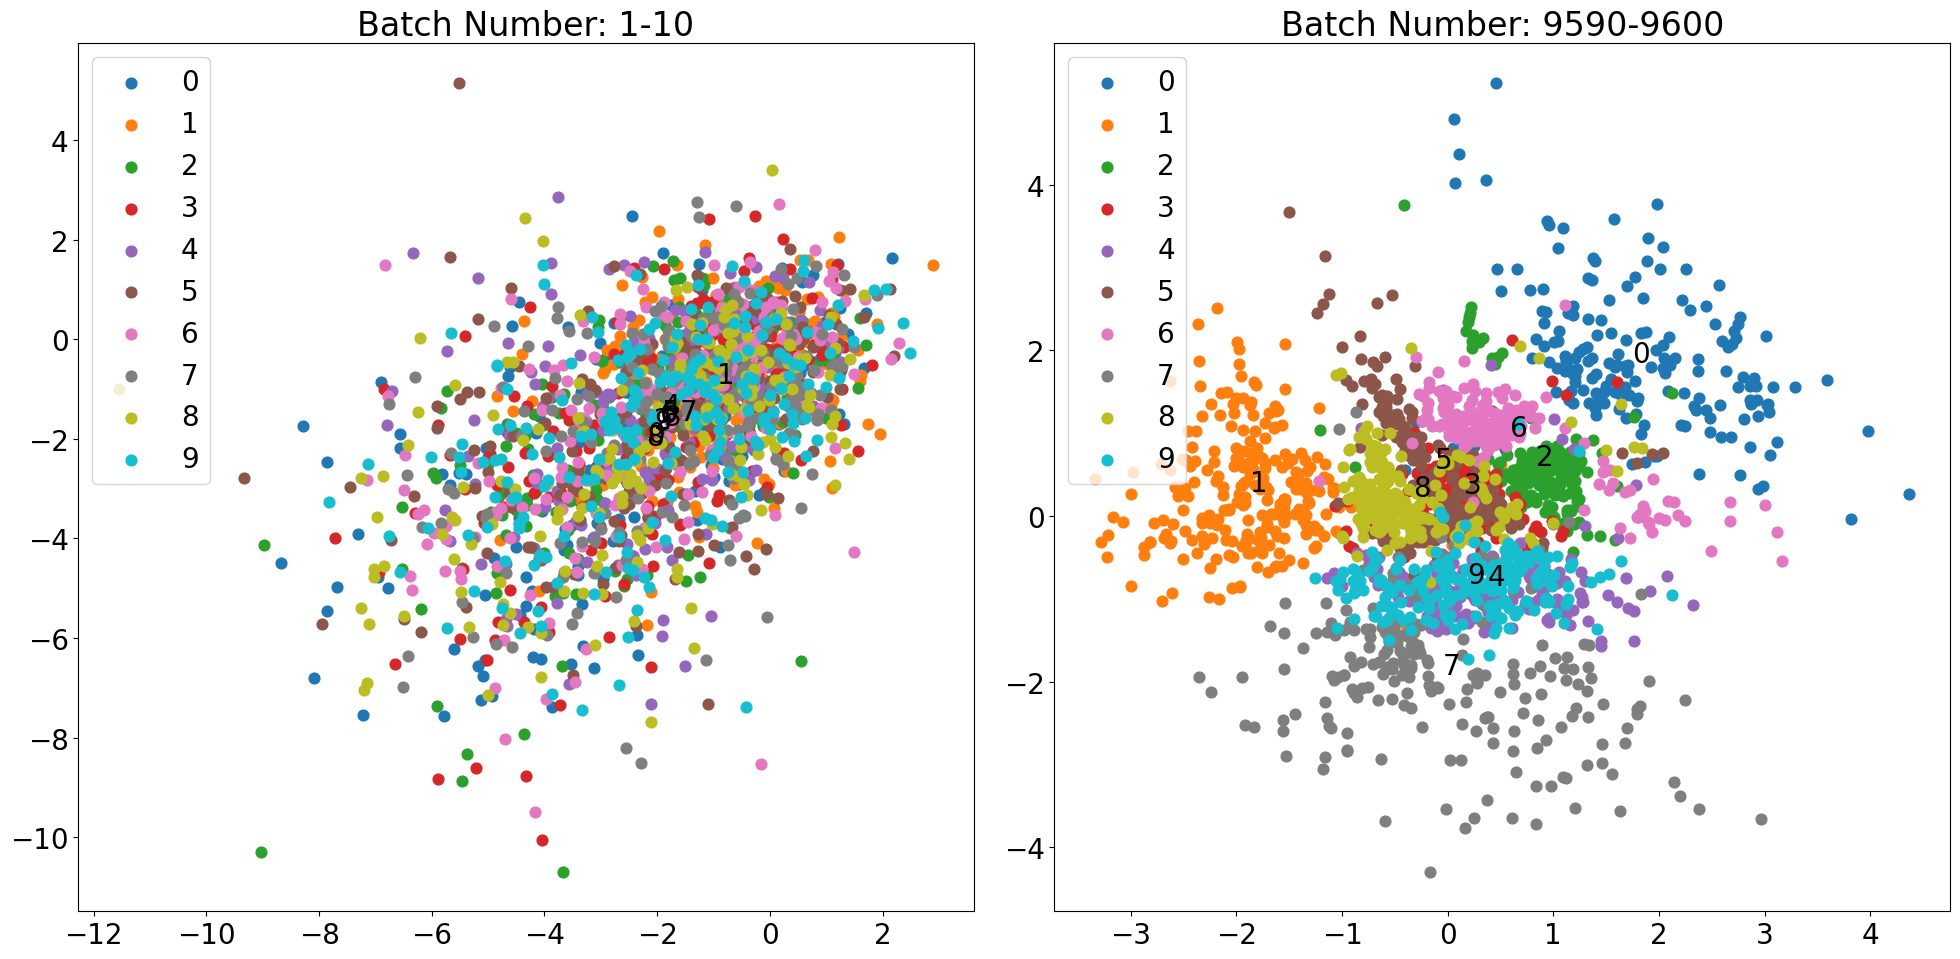

In [85]:
cmap_keyword = "tab10"
cmap = plt.get_cmap(cmap_keyword)

b_num_init =20
b_num_end = -20

plt.rcParams.update({'font.size': 20})  # Sets the global default font size to 20

fig, axs = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)

for label in range(10):
    x = z_np[:b_num_init,:,0][labels_np[:b_num_init,:] == label] 
    # x becomes one-dimensional because mask indexing with a boolean array pulls out individual elements that meet the condition and does not preserve the multidimensional structure of the original array. This is a common behavior in NumPy when filtering arrays using conditions.
    y = z_np[:b_num_init,:,1][labels_np[:b_num_init,:] == label]
    axs[0].scatter(x, y, color=cmap(label/9), label=label, s=60)
    axs[0].annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
axs[0].legend(loc="upper left")
axs[0].set_title(f'Batch Number: 1-10')

for label in range(10):
    x = z_np[b_num_end:,:,0][labels_np[b_num_end:,:] == label]
    y = z_np[b_num_end:,:,1][labels_np[b_num_end:,:] == label]
    axs[1].scatter(x, y, color=cmap(label/9), label=label, s=60)
    axs[1].annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
axs[1].legend(loc="upper left")
axs[1].set_title(f'Batch Number: 9590-9600')

plt.show()

In [70]:
model.to("cpu")

VAE(
  (encoder): Encoder(
    (lr): Linear(in_features=784, out_features=300, bias=True)
    (lr2): Linear(in_features=300, out_features=100, bias=True)
    (lr_ave): Linear(in_features=100, out_features=2, bias=True)
    (lr_var): Linear(in_features=100, out_features=2, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lr): Linear(in_features=2, out_features=100, bias=True)
    (lr2): Linear(in_features=100, out_features=300, bias=True)
    (lr3): Linear(in_features=300, out_features=784, bias=True)
    (relu): ReLU()
  )
)

In [111]:
label = 0
x_zero_mean = np.mean(ave_np[:b_num_end,:,0][labels_np[:b_num_end,:] == label]) # 1d
y_zero_mean = np.mean(ave_np[:b_num_end,:,1][labels_np[:b_num_end,:] == label]) # 1d

label = 1
x_one_mean = np.mean(ave_np[:b_num_end,:,0][labels_np[:b_num_end,:] == label]) # 1d
y_one_mean = np.mean(ave_np[:b_num_end,:,1][labels_np[:b_num_end,:] == label]) # 1d

z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)
z_one = torch.tensor([x_one_mean,y_one_mean], dtype = torch.float32)


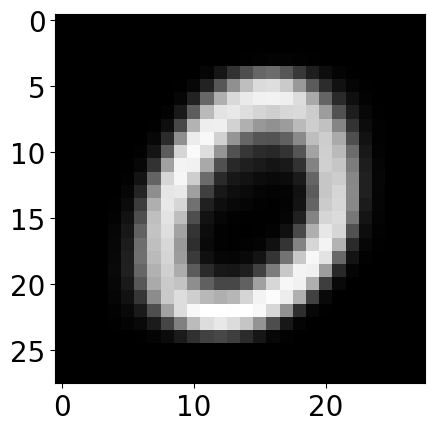

In [112]:
output = model.decoder(z_zero)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')
# The image of zero with batch number around 1000 is already pretty close to zero!!

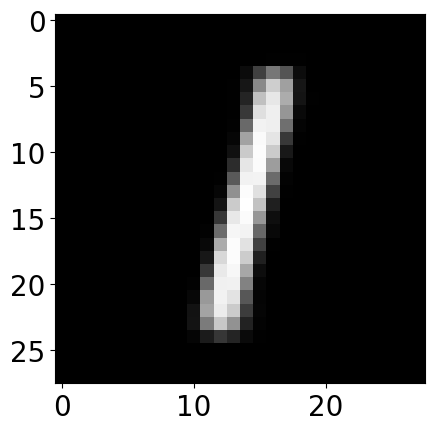

In [113]:
output = model.decoder(z_one)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')

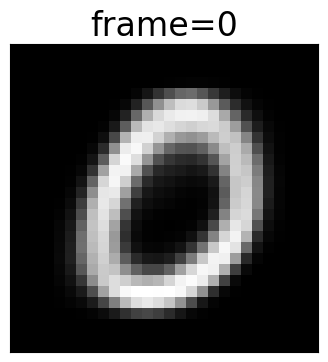

In [117]:
def plot(frame):
    plt.cla()                      # 現在描写されているグラフを消去
    z_zerotoone = ((99 - frame) * z_zero +  frame * z_one) / 99
    output = model.decoder(z_zerotoone)
    np_output = output.detach().numpy().copy()
    np_image = np.reshape(np_output, (28, 28))
    plt.imshow(np_image, cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title(f"frame={frame}")

fig = plt.figure(figsize=(4,4))
ani = animation.FuncAnimation(fig, plot, frames=99, interval=100)
rc('animation', html='jshtml')
#ani.save("./vae_zerotone.gif", writer="imagemagick")
ani

確立モデルに潜在変数Zを導入したら複雑な分布をより単純な分布を使って表すことが可能になります。潜在変数を導入することは，同時分布
を設計することに相当します。ここが全ての始まりです。観測データと潜在変数にどのような依存関係があるのかを同時分布として設定してしまうわけです。

変分ベイズを含む従来のベイズ推定の手法では，計算が煩雑になるという欠点があります。一方で，VAEでは近似分布のみならず，真の分布もDNNによって推定しますので，確率的勾配法を用いて一気通貫にパラメータを最適化することができます。

EM algorithm:
 - 潜在変数を含む確率モデルの点推定を行う手法。
 - Mアルゴリズムでは，潜在変数をとパラメータを区別します。
 - EMアルゴリズムではを計算できるという立場を取ります。

Variational Bayes:
 - 変分ベイズは潜在変数を含む確率モデルのベイズ推定を行うための手法です。
 - 潜在変数をとパラメータを区別せずに、両者を一括してZと表します。
 - 変分ベイズではを計算できないという立場を取ります。
 - 変分ベイズは，事後分布を別の新しい分布で近似してしまおうという大胆かつ汎用性の高い手法です。

*Ref: https://academ-aid.com/ml/vae*